# Plotting auxiliary spectra

We will download some noise-monitoring data from LIGO and play it as a sound.

(The following two cells of code are preliminaries which you can skip.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

from gwpy.detector import ChannelList, Channel
from gwpy.timeseries import TimeSeries
from gwpy.time import tconvert

## Available channels

Let's retrieve a list of all available channels from GWOSC, and see how they are distributed in terms of sampling rate and detector.

In [3]:
channel_list = ChannelList.query_nds2('*', host='losc-nds.ligo.org' )

print("Found {0} channels\n".format(len(channel_list)))
print("Printing first 10 channels ...")
for chan in channel_list[0:10]:
    print(chan.name, chan.sample_rate)

Found 1263 channels

Printing first 10 channels ...
H1:ASC-AS_A_DC_NSUM_OUT_DQ 2048.0 Hz
H1:ASC-CHARD_P_IN1_DQ 256.0 Hz
H1:ASC-CHARD_P_INMON 16.0 Hz
H1:ASC-CHARD_P_OUT_DQ 512.0 Hz
H1:ASC-CHARD_Y_IN1_DQ 256.0 Hz
H1:ASC-CHARD_Y_INMON 16.0 Hz
H1:ASC-CHARD_Y_OUT_DQ 512.0 Hz
H1:ASC-CSOFT_P_IN1_DQ 256.0 Hz
H1:ASC-CSOFT_P_INMON 16.0 Hz
H1:ASC-CSOFT_P_OUT_DQ 512.0 Hz


There are 1263 channels in total


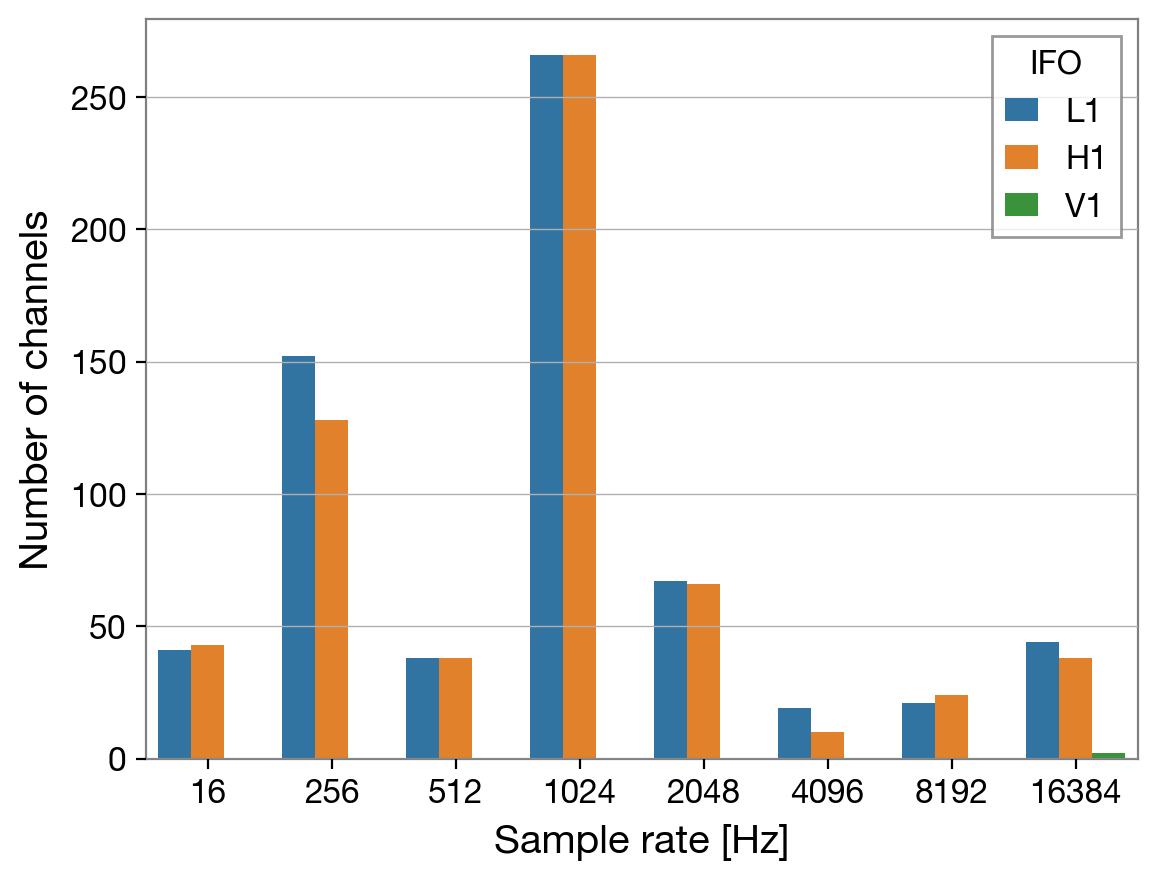

In [12]:
sample_rates = sorted(list(set([int(chan.sample_rate.value) for chan in channel_list])))
detectors = list(set([chan.ifo for chan in channel_list]))

rows = []
for sr in sample_rates:
    channels = [c for c in channel_list if c.sample_rate.value == sr]
    for ifo in detectors:
        channels_ifo = [c for c in channels if c.ifo == ifo]
        rows.append(dict(IFO=ifo, sample_rate=sr, n_channels=len(channels_ifo)))
        # print(f"There are {len(channels_ifo)} {ifo} channels sampled at {sr} Hz")
df = pd.DataFrame(rows)

ax = sns.barplot(df, x='sample_rate', y='n_channels', hue='IFO')
ax.set_ylabel('Number of channels')
ax.set_xlabel('Sample rate [Hz]');

print("There are {0} channels in total.".format(len(channel_list)))

## Channel properties

In [14]:
detector = 'L1'
sample_rate = 16

channels = [c for c in channel_list if c.ifo == detector]

In [27]:
# specify start and end times
t0 = gps # tconvert('Jan 16 2020 17:00:00')
duration_in_minutes = 60

start_time = int(t0 - 0.5*duration_in_minutes*60)
end_time = int(t0 + 0.5*duration_in_minutes*60)

# GWOSC NDS2 server name from which to download data
server = 'losc-nds.ligo.org'

In [28]:
bad_times_dict = {
    'H1': [ (1239130112, 1239134208)],
    'L1': [(1247261568, 1247261824),
        (1266183936, 1266185600),
        (1267377472, 1267377600),
        (1267377664, 1267377728),
        (1267556672, 1267557056),
        (1267559296, 1267559424),
        (1267564160, 1267564480),
        (1268516633, 1268516672)]
}

In [29]:
for ifo, bad_times in bad_times_dict.items():
    for bad_start, bad_end in bad_times:
        if (bad_start <= start_time < bad_end) or (bad_start < end_time <= bad_end):
            print("Bad time for {0}: {1} - {2}".format(ifo, bad_start, bad_end))

In [25]:
start_time, end_time

(1242441167, 1242444767)

In [22]:
gps

1242442967.4

In [7]:
import os

In [8]:
output_dir = 'data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
failed_channels = []
for c in tqdm(channels):
    try:
        data_dict[c.name] = TimeSeries.fetch(c.name, start=start, end=end, host=server)
    except ValueError:
        failed_channels.append(c.name)

  0%|          | 0/648 [00:00<?, ?it/s]

In [10]:
from gwosc.datasets import event_gps
gps = event_gps("GW190521")

In [12]:
gps

1242442967.4

In [31]:
hdata = TimeSeries.fetch_open_data('H1', t0-2, t0+2)

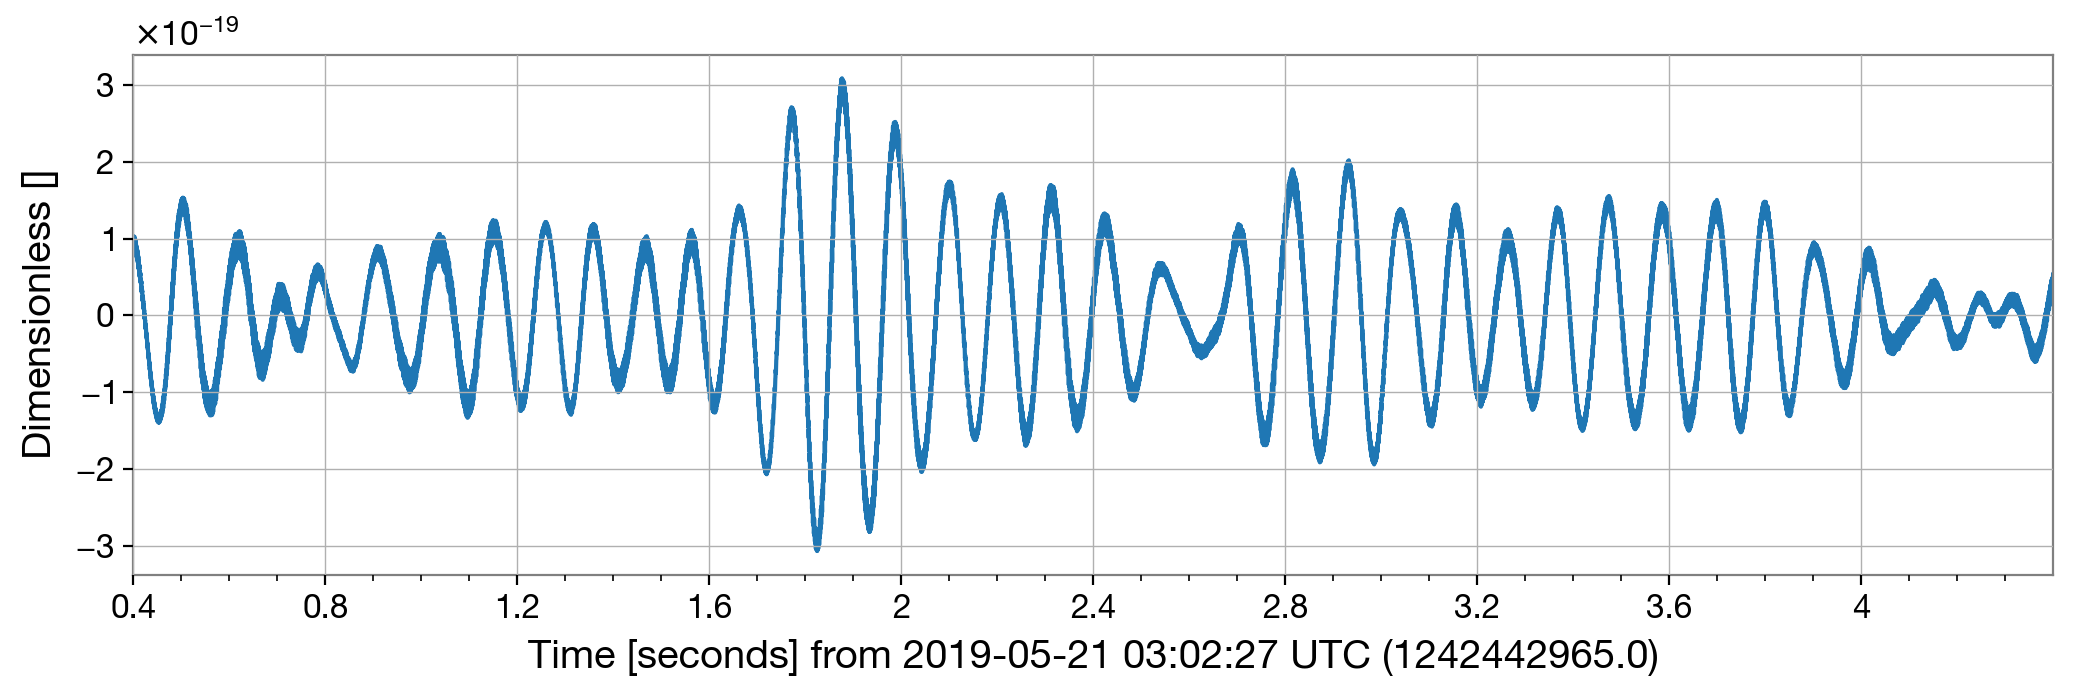

In [34]:
hdata.plot();

In [35]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(20, 100, hdata.sample_rate)

In [36]:
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

In [37]:
zpk = filter_design.concatenate_zpks(bp, *notches)

In [38]:
hfilt = hdata.filter(zpk, filtfilt=True)

In [39]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))


/opt/miniconda3/envs/gwtunes/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


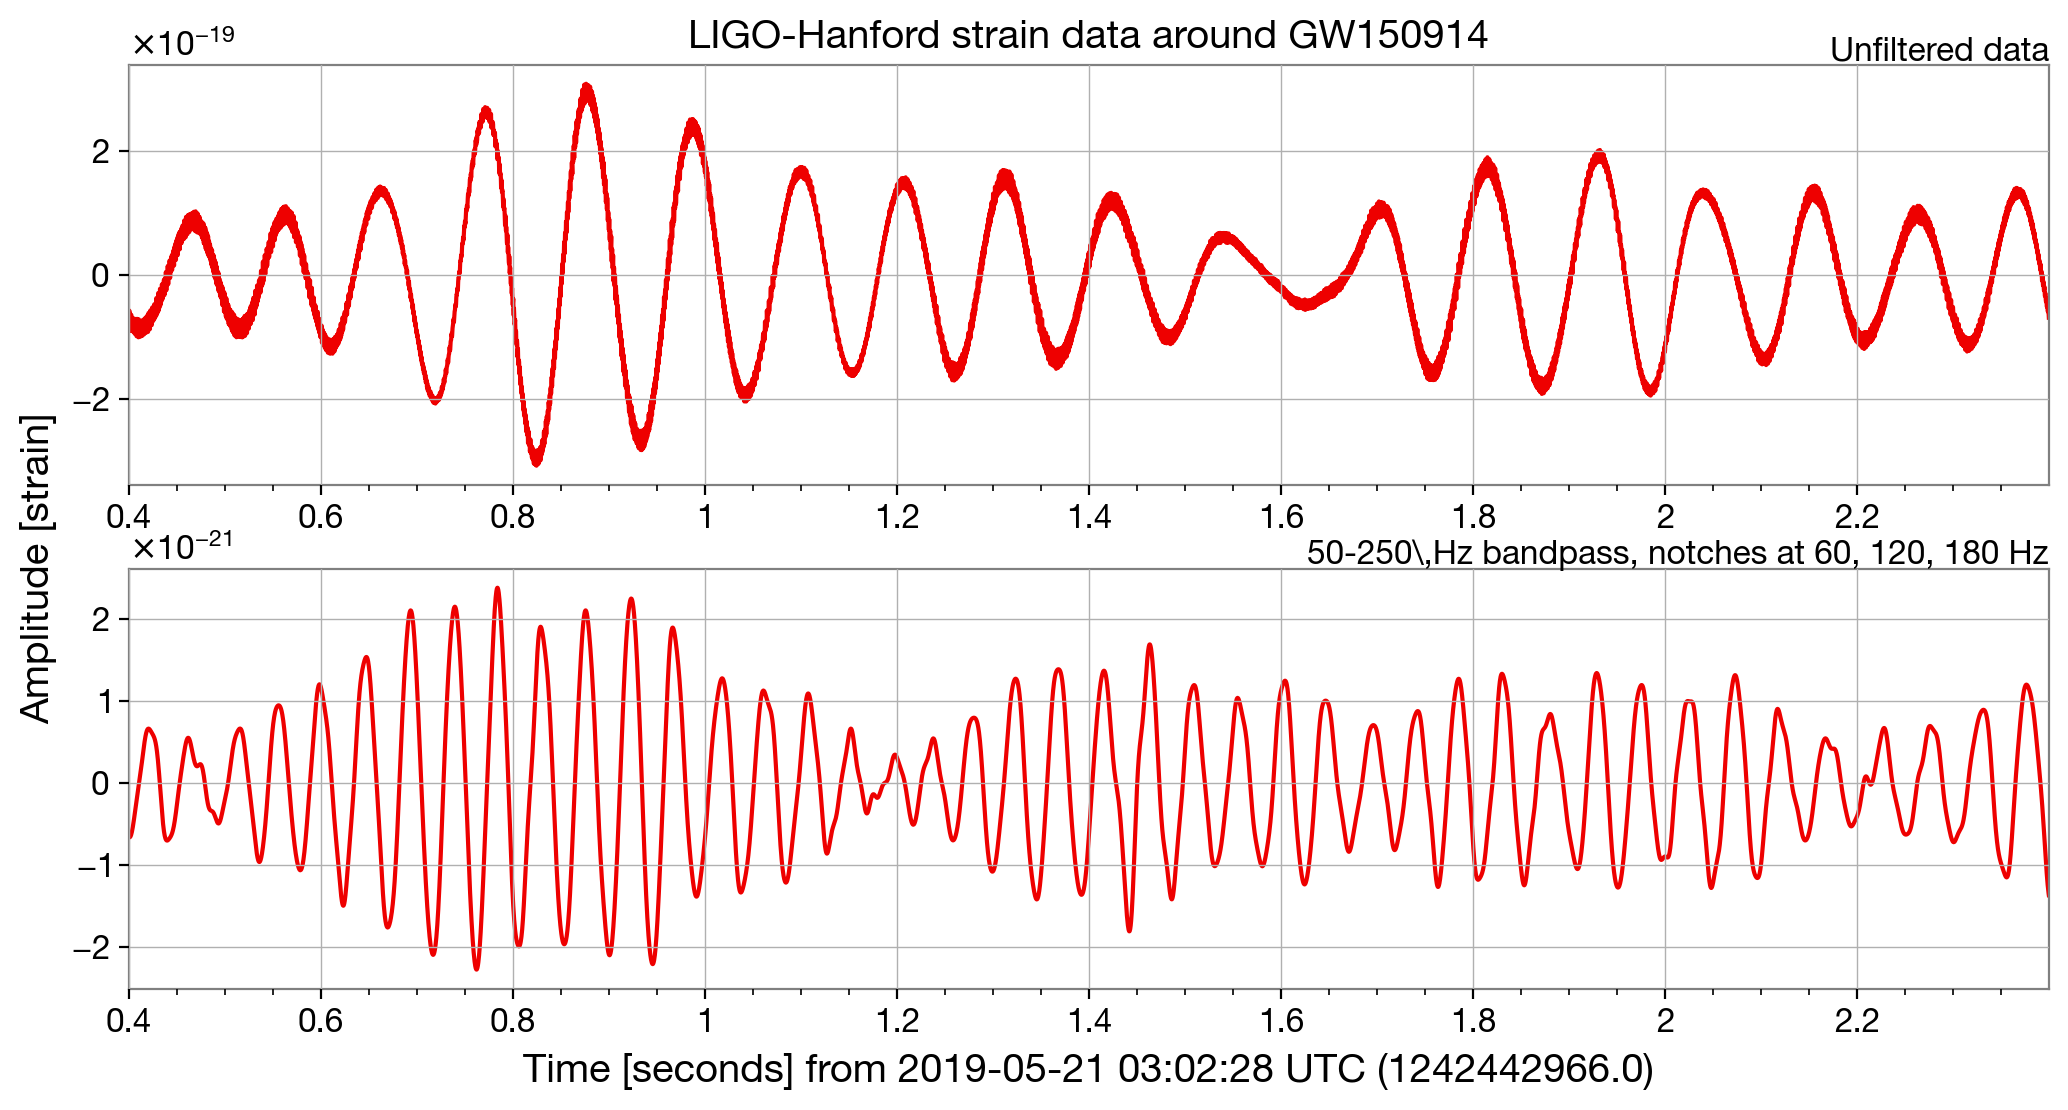

In [40]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()


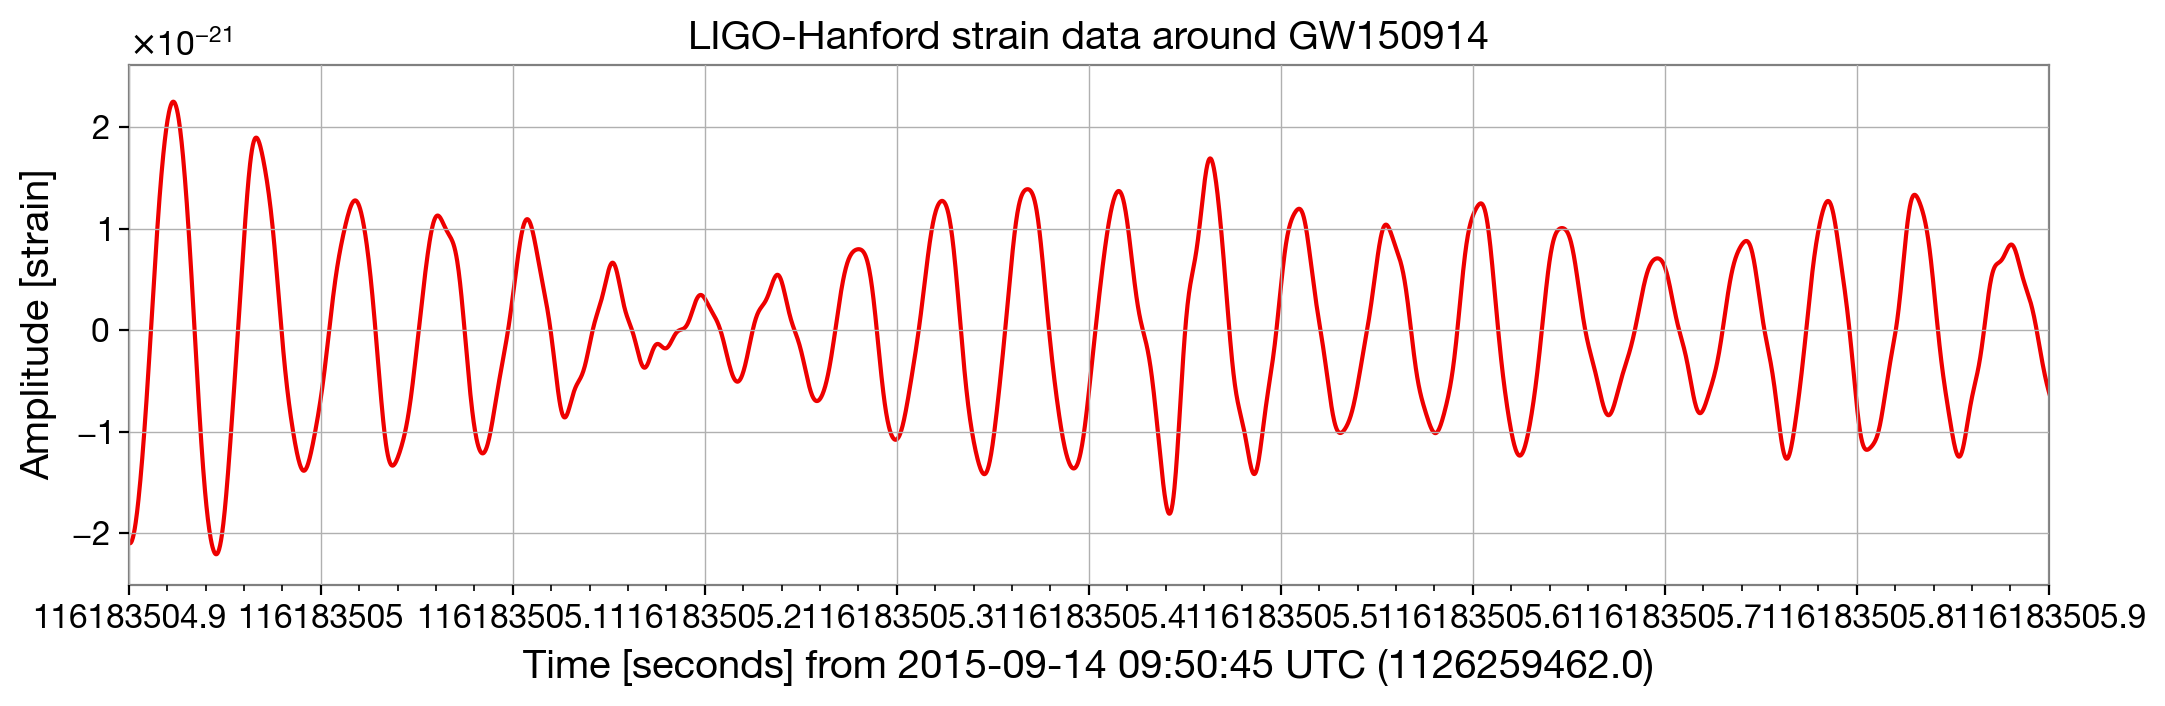

In [43]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(t0-0.5, t0+0.5)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()


In [46]:
import gwpy.time

In [49]:
gwpy.time.from_gps(start_time).strftime('%Y-%m-%d %H:%M:%S')

'2019-05-21 02:32:29'

In [50]:
gwpy.time.tconvert('Jan 16 2020 17:00:00')

LIGOTimeGPS(1263229218, 0)